1. Mount Google Drive and Load Data
2. Exploratory Data Analysis(EDA)
3. Handling Missing values
4. Feature Engineering
5. Data Normalizstion(StandardScaler)
6. Train VAlidation Test Split
7. Modeling
8. Evaluation
9. Testing and Final Results
10. TimeSeriesSplit: preserves temporal order


1. Mount Google Drive in Colab


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Navigate the file

In [2]:
file_path='/content/drive/My Drive/Colab Notebooks/coco cola.csv'

In [3]:
# import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [4]:
#Load the Data

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/coco cola.csv', parse_dates= True, index_col='Date')
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-02,0.263021,0.270182,0.263021,0.263021,0.051133,806400
1962-01-03,0.259115,0.259115,0.253255,0.257161,0.049994,1574400
1962-01-04,0.257813,0.261068,0.257813,0.259115,0.050374,844800
1962-01-05,0.259115,0.262370,0.252604,0.253255,0.049234,1420800
1962-01-08,0.251302,0.251302,0.245768,0.250651,0.048728,2035200


2. Exploratory Data Analysis

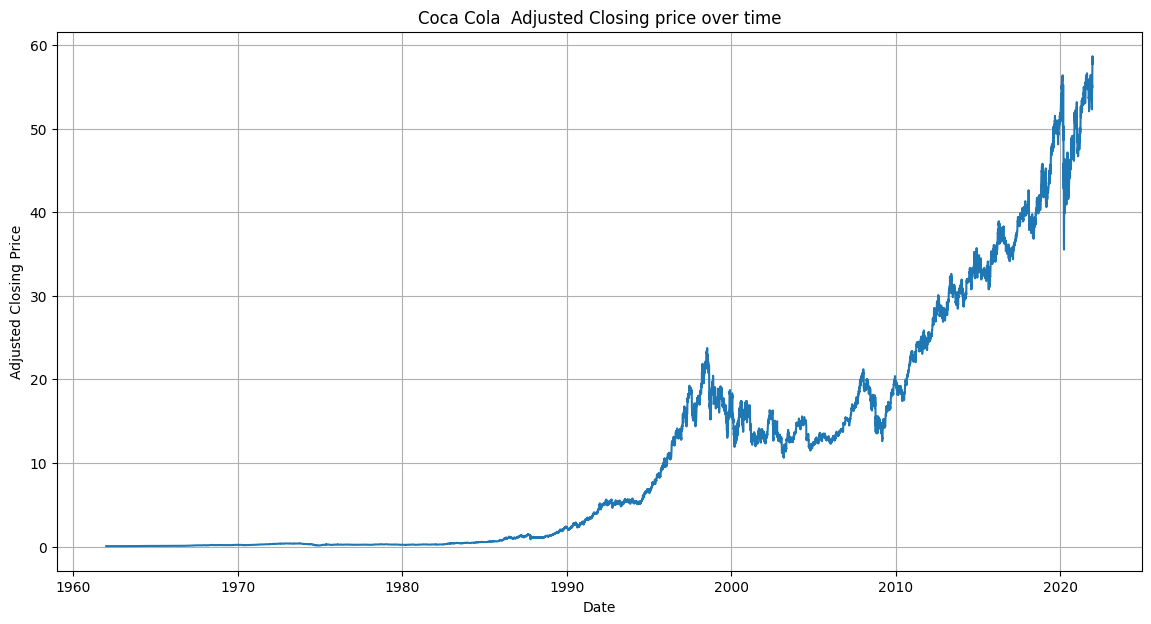

In [5]:

plt.figure(figsize=(14,7))
plt.plot(data['Adj Close'])
plt.title('Coca Cola  Adjusted Closing price over time')
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price')
plt.grid(True)
plt.show()



Summary


In [6]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,15096.000000,15096.000000,15096.000000,15096.000000,15096.000000,1.509600e+04
mean,16.056202,16.188428,15.921876,16.060734,11.367487,9.032904e+06
std,16.939301,17.064336,16.811753,16.941712,14.253637,7.935744e+06
min,0.192708,0.193359,0.182292,0.192057,0.037855,7.680000e+04
25%,0.860677,0.869792,0.854167,0.860352,0.242312,2.812800e+06
50%,9.328125,9.398438,9.218750,9.351562,4.642848,7.585200e+06
75%,28.875000,29.167500,28.563125,28.901562,17.251080,1.291275e+07
max,59.810001,60.130001,59.619999,60.130001,58.650002,1.241690e+08


Check Missing Values

In [ ]:
data.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [8]:
#Handeling missing Values
data.fillna(method='ffill',inplace=True)

<ipython-input-8-3b07075f2bfa>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill',inplace=True)


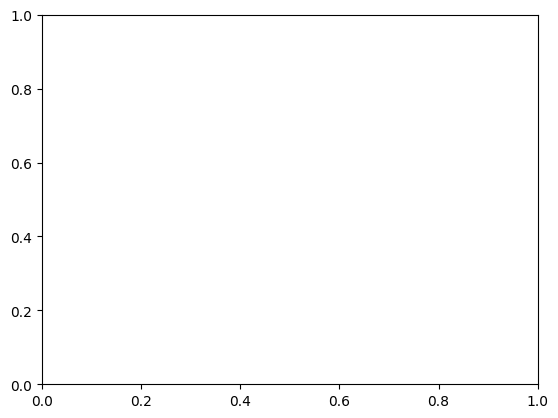

In [11]:
#Check for extreme values using z-scores or boxplot
import seaborn as sns
sns.boxplot(df=data[['Close','Volume']])
data['LogVolume']= np.log1p(data['Volume'])


3. Feature Engineering

In [ ]:
#create time Feature
data['Month']=data.index.month
data['Day'] = data.index.day
data['Weekday'] = data.index.weekday

#Create lag and rolling feature
data['Lag1'] = data['Adj Close'].shift(1) # value of One time step Earlier.
data['Lag7'] = data['Adj Close'].shift(7) # value of Seven time step Earlier.
data['RollingMean7'] = data['Adj Close'].rolling(window=7).mean()
data['RollingStd7'] = data['Adj Close'].rolling(window=7).std()

# drop rows with NaN
data.dropna(inplace=True)

4. Data Normaliztion

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Features= ['Volume','Month', 'Weekday', 'Lag1','Lag7','RollingMean7','RollingStd7']
data[Features] = scaler.fit_transform(data[Features])

check mean and standard deviations

In [ ]:
print(data[Features].mean())
print(data[Features].std())

Volume          9.041302e-17
Month          -9.418023e-17
Weekday        -3.249218e-17
Lag1            1.205507e-16
Lag7            6.027535e-17
RollingMean7    0.000000e+00
RollingStd7     0.000000e+00
dtype: float64
Volume          1.000033
Month           1.000033
Weekday         1.000033
Lag1            1.000033
Lag7            1.000033
RollingMean7    1.000033
RollingStd7     1.000033
dtype: float64


Prepare Feature and Target

In [ ]:
x= data[Features]
y= data['Adj Close']

5. Trian, Validation and Test Split

In [ ]:
train_size = int(len(data) *0.7)
val_size = int(len(data) * 0.15)
x_train = x[:train_size]
y_train = y[:train_size]
x_val =x[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]
x_test = x[train_size+val_size:]
y_test = y[train_size+val_size:]

6. Train Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
linearreg = LinearRegression()
linearreg.fit(x_train, y_train)
val_pred_lr = linearreg.predict(x_val)


7. Train Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)

val_pred_rf = rf.predict(x_val)


In [ ]:
# TimeSeriesSplit: preserves temporal order
# Create RandomForestRegressor
# GridSearchCV with TimeSeriesSplit
# Fit on training + validation combined (for best generalization)
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}
rf_base = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_base,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=tscv,
                           verbose=1,
                           n_jobs=-1)
x_train_val = np.concatenate((x_train, x_val))
y_train_val = pd.concat([y_train, y_val])

grid_search.fit(x_train_val, y_train_val)
# Best estimator
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)




Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


8. Model Evaluation

In [ ]:
# Root Mean Squared Error (RMSE)
# Mean Absolute Error (MAE)
#R-squared or Coefficient of Determination(R^2)
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


#from sklearn.metrics import mean_squared_error
#mse = mean_squared_error(y_true, y_pred)
#rmse = np.sqrt(mse)

def evaluate_model(name, y_true, y_pred):
    print(f'{name} Evaluation:')
    print(f'MAE:  {mean_absolute_error(y_true, y_pred):.4f}')
    rmse =np.sqrt(mean_squared_error(y_true,y_pred))
    print(f'RMSE:{rmse:.4f}')
    #print(f'RMSE: {mean_squared_error(y_true, y_pred, squared=False):.4f}')
    print(f'R²:   {r2_score(y_true, y_pred):.4f}\n')

evaluate_model("Linear Regression (Validation)", y_val, val_pred_lr)
evaluate_model("Random Forest (Validation)", y_val, val_pred_rf)


Linear Regression (Validation) Evaluation:
MAE:  0.1402
RMSE:0.2024
R²:   0.9982

Random Forest (Validation) Evaluation:
MAE:  0.6925
RMSE:1.5036
R²:   0.9032



10. Test Set Evaluation

Random Forest - Test Set Evaluation:
MAE:  16.4357
RMSE:18.1961
R²:   -4.4713



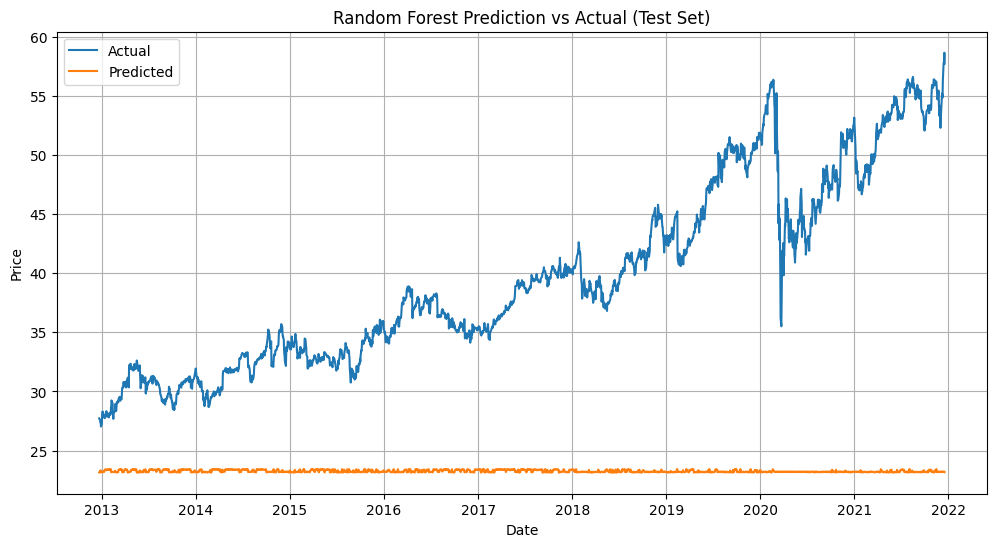

In [ ]:
# Choose best model (Random Forest here)
test_pred = rf.predict(x_test)
evaluate_model( "Random Forest - Test Set" ,y_test, test_pred)

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, test_pred, label='Predicted')
plt.title('Random Forest Prediction vs Actual (Test Set)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


Feature Importance

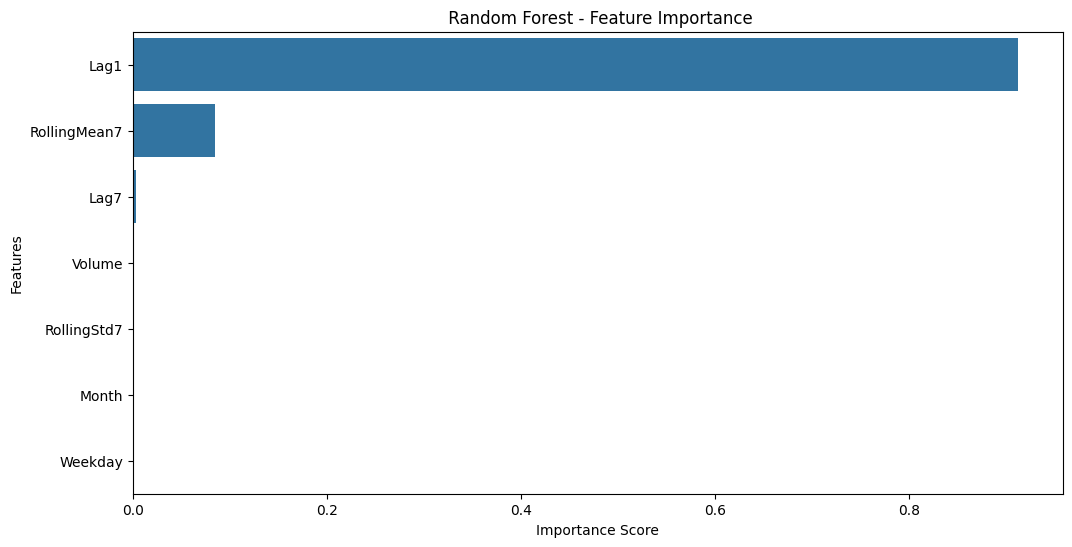

In [ ]:
# Feature Importance
# Random Forest

import seaborn as sns

importances = rf.feature_importances_
feat_df = pd.Series(importances, index=Features).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=feat_df.values, y=feat_df.index)
plt.title(" Random Forest - Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()
